## Step 1: Download images of dinosaurs

In [2]:
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [3]:
searches = 'pterodactyl','parasaurolophus','triceratops','brachiosaurus','stegosaurus','trex','Giganotosaurus'
path = Path('dinosaurs')

In [ ]:
for o in searches:
dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo',max_images=200))
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [4]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256)],
    batch_tfms=aug_transforms(size=224),
).dataloaders(path)

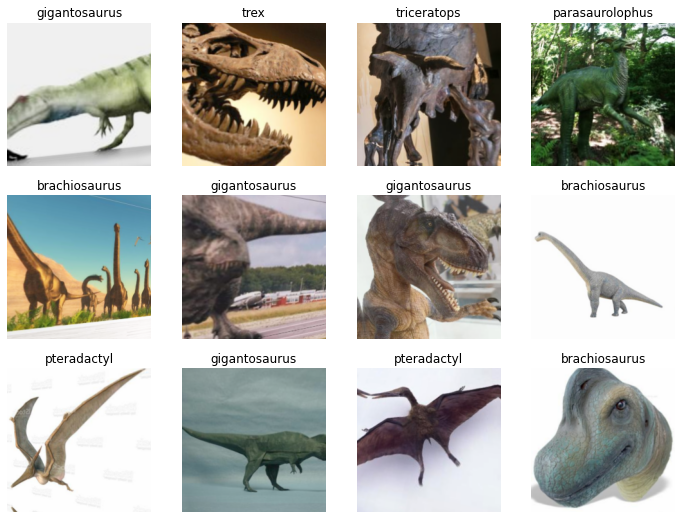

In [16]:
dls.show_batch(max_n=12)

In [5]:
learn = vision_learner(dls, 'seresnext50_32x4d', metrics=error_rate)

In [8]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,time
0,2.382311,1.405526,0.438914,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.234153,0.962022,0.303167,00:08
1,1.099688,0.881812,0.294118,00:07
2,0.987133,0.853045,0.253394,00:07
3,0.857848,0.964415,0.276018,00:07
4,0.773988,0.994656,0.276018,00:07
5,0.697529,1.080226,0.285068,00:07
6,0.637822,1.000570,0.271493,00:07
7,0.585805,1.029083,0.262443,00:07
8,0.535863,1.041106,0.257919,00:07
9,0.487678,1.023052,0.257919,00:07


In [6]:
learn.save('dino2_resnext50')

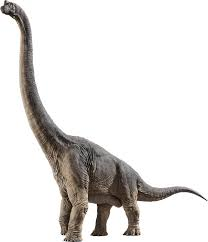

In [7]:
img = PILImage.create('brachio.jpg')
img

In [15]:
def find_character(img):
    dinosaur,_,probs = learn.predict(img)
    probs = [o.item() for o in probs]
    return dinosaur,dict(zip(dls.vocab,probs))

In [16]:
dinosaur,probs=find_character(img)

In [17]:
dinosaur

'brachiosaurus'